# Composing Maps

Geographic visualizations provide rich data storytelling. However, they are most effective with knowledge of three key fundamentals that help drive map visualizations in Altair and Vega-Lite:


* **Data Types:** Geographic data is often packaged in specific formats such as TopoJSON or GeoJSO that define the points and shapes that need to be mapped. Practically, this means that Altair and Vega-Lite will automatically draw those shapes when geographic source is detected. 
* **[Projection](https://vega.github.io/vega-lite/docs/projection.html):** Which translates latitude and longitude from the Earth's sphere shape to x and y coordinates on 2D chart. 
* **Composition:** The layering of various geographic features to provide context and visual cues about the geography and its data attributes that are being visualized. In this notebook, we will reconstruct a map of the London tube lines, which is one of the examples featured in the [Vega-Lite example gallery](https://vega.github.io/vega-lite/examples/geo_layer_line_london.html)



In [40]:
import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Obtaining Data

The London Tube line maps rely on three data sources, all obtained from [vega-datasets](https://github.com/altair-viz/vega_datasets): 

1. **London Boroughs**: This is a TopoJSON formatted file that provides details on the polygons that make up each borough of London. Within the file a geometry collection identifies each polygon that corresponds to each borough. 
2. **Tube Lines**: Also a TopoJSON file but instead of polygons the tube lines are expressed as LineStrings which outline the path of each train. 
3. **London Centroids**: This is a standard JSON data file that includes the name of each borough and the latitude and longitude of its center. This file will allow us to place text identifying each borough. 

In [41]:
boroughs = alt.topo_feature(data.londonBoroughs.url, 'boroughs')
lines = alt.topo_feature(data.londonTubeLines.url,'line')
centroids = data.londonCentroids.url


## Projection

Various projections are best suited for specific regions of the world or specific applications with some favoring accurate portrayal of land mass while others emphasizing familiarity and navigation. 

Below are four projections of London and its boroughs. For most use cases, 'Mercator' is the projection that is most often needed and indeed it is the default for Altair and vega-lite. Projections are a top-level attribute and are configured directly with the chart as in 

```
alt.Chart().project(
    type='mercator'
    )
```
Various [optional properties](https://vega.github.io/vega-lite/docs/projection.html#properties) control how the projection is rendered including its scale and center. However for most charts, automatic calculations will ensure that all marks are visible and the geographic center of all marks placed in the middle. 

Because the data source `londonBoroughs` is a TopoJSON, the encodings for drawing the polygons are also automatically applied and not specified. 

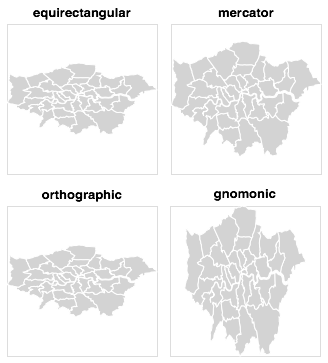

In [42]:

base_map = alt.Chart(boroughs, width=150, height=150).mark_geoshape(stroke='white', fill='lightgrey').encode()

projections = ['equirectangular', 'mercator', 'orthographic', 'gnomonic']
charts = [base_map.project(proj).properties(title=proj)
          for proj in projections]

(charts[0] | charts[1]) & (charts[2] | charts[3])

# Composition

Mercator seems to be the most straightforward appearance so we will continue to using the mercator projection as the base map. To the base map, we will add a layer of the tube lines. To do this we will continue to use Altair's operator composition where `+` adds two charts as layers. 



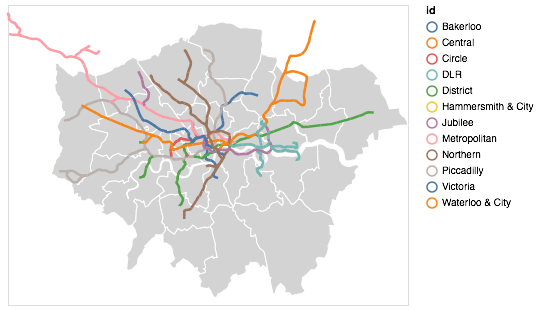

In [43]:
mercator_base = alt.Chart(data=boroughs
        , width=700
        , height=500
        ).mark_geoshape(
            stroke='white'
            , fill='lightgrey'
            ).encode().project(
                type='mercator'
            )

lines_layer = alt.Chart(lines).mark_geoshape(
    strokeWidth=2.5
    ).encode(
        stroke='id:N'
        )


mecator_base + lines_layer

Of course what would a map of the tube lines be if the lines were not in the eponymous colors. Let's define a scale that assigns each line to the correct color. 

In [44]:

tube_lines = [
              "Bakerloo",
              "Central",
              "Circle",
              "District",
              "DLR",
              "Hammersmith & City",
              "Jubilee",
              "Metropolitan",
              "Northern",
              "Piccadilly",
              "Victoria",
              "Waterloo & City"
            ]
                    
line_colors = [
              "rgb(137,78,36)",
              "rgb(220,36,30)",
              "rgb(255,206,0)",
              "rgb(1,114,41)",
              "rgb(0,175,173)",
              "rgb(215,153,175)",
              "rgb(106,114,120)",
              "rgb(114,17,84)",
              "rgb(0,0,0)",
              "rgb(0,24,168)",
              "rgb(0,160,226)",
              "rgb(106,187,170)"
            ]

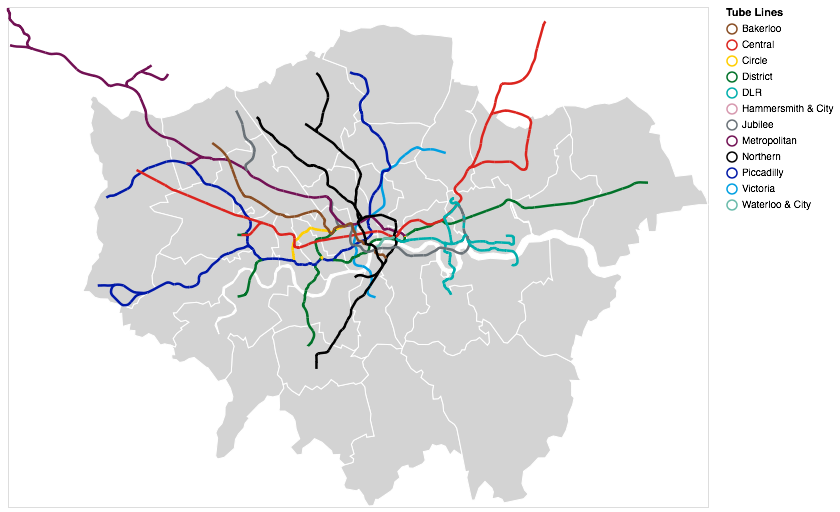

In [45]:

lines_layer = alt.Chart(lines).mark_geoshape(
    strokeWidth=2.5
    ).encode(
        alt.Stroke('id:N'
            , scale=alt.Scale(domain=tube_lines, range=line_colors)
            ,title='Tube Lines'
                  )
                )

mercator_base + lines_layer

## Adding More Context

As a last element, we will add in the names of each London borough. This will a use `text` mark with latitude and longitude encoded from the dataset. Note the use of `latitude` and `longitude` instead of `X` and `Y`. Because this mark will be added to a mercator projection those are the correct channels to use or else the axes cannot be inferred and shared. 

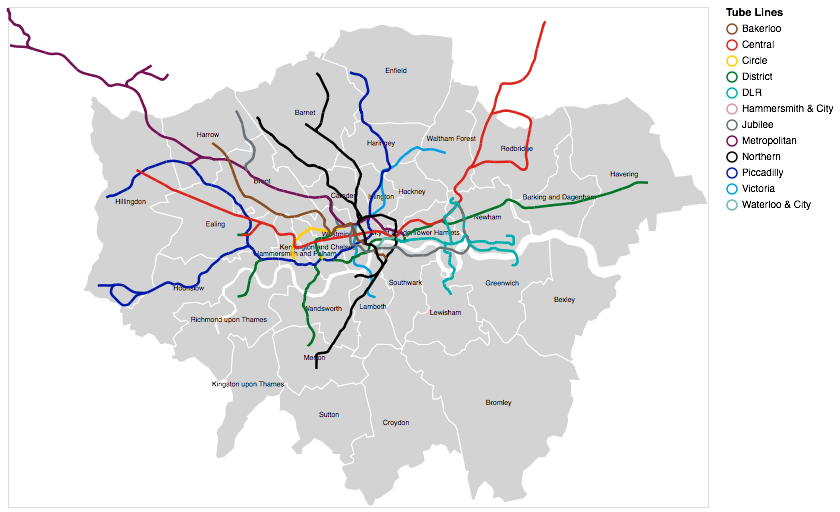

In [46]:

text = alt.Chart(centroids).encode(
    longitude='cx:Q',
    latitude='cy:Q'
    ).mark_text(fontSize=7).encode(
        alt.Text('name', type='nominal')
    )


mercator_base  + text + lines_layer